### Name : Yuvraj Pardeshi
### Roll No : 43548
### Sub - NLP
### Assignment No - 4  

Create a transformer from scratch using the Pytorch library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [3]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [6]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [7]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [8]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

In [9]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(10):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

C:\Users\Yuvraj Pardeshi\miniconda3\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch: 1, Loss: 8.692754745483398
Epoch: 2, Loss: 8.551765441894531
Epoch: 3, Loss: 8.485379219055176
Epoch: 4, Loss: 8.429370880126953
Epoch: 5, Loss: 8.374214172363281
Epoch: 6, Loss: 8.303865432739258
Epoch: 7, Loss: 8.224189758300781
Epoch: 8, Loss: 8.148188591003418
Epoch: 9, Loss: 8.056589126586914
Epoch: 10, Loss: 7.982827663421631


In [12]:
transformer.eval()

# Generate random sample validation data
val_src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
val_tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
# Generate random sample training data
train_src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
train_tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

with torch.no_grad():

    val_output = transformer(val_src_data, val_tgt_data[:, :-1])
    val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_tgt_data[:, 1:].contiguous().view(-1))
    train_output = transformer(train_src_data, train_tgt_data[:, :-1])
    train_loss = criterion(train_output.contiguous().view(-1, tgt_vocab_size), train_tgt_data[:, 1:].contiguous().view(-1))
    print(f"Validation Loss: {val_loss.item()}   training Loss: {train_loss.item()}")

Validation Loss: 8.67835807800293   training Loss: 8.680340766906738


In [11]:
print(tgt_data[:, :-1])

tensor([[4807,  903, 4837,  ..., 4122,   86, 2876],
        [2018,  788, 2166,  ...,  382, 2432, 4925],
        [3490,  666, 2005,  ...,  548, 1737,  956],
        ...,
        [1907, 4830,  911,  ..., 3360, 2981, 1141],
        [  29,  696, 4351,  ..., 4437, 1001,  548],
        [ 229, 1765, 3786,  ..., 4626, 2491,  943]])


In [13]:
!python -c "import torchtext"

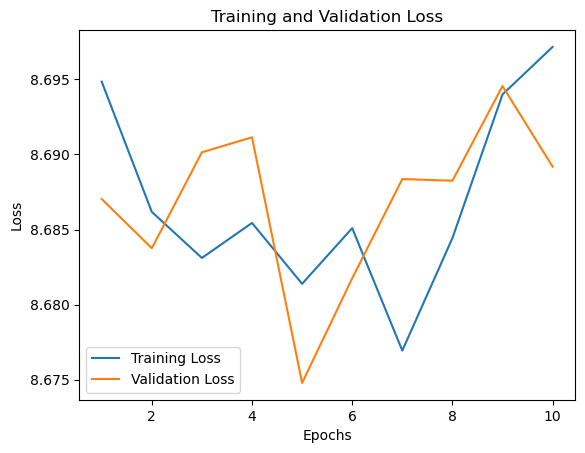

In [13]:
import matplotlib.pyplot as plt

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    # Your training code here...
    # This is just a placeholder for the training loop

    # Generate random sample training data
    train_src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
    train_tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

    train_output = transformer(train_src_data, train_tgt_data[:, :-1])
    train_loss = criterion(train_output.contiguous().view(-1, tgt_vocab_size), train_tgt_data[:, 1:].contiguous().view(-1))
    train_losses.append(train_loss.item())

    # Generate random sample validation data
    val_src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
    val_tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

    val_output = transformer(val_src_data, val_tgt_data[:, :-1])
    val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_tgt_data[:, 1:].contiguous().view(-1))
    val_losses.append(val_loss.item())

# Plotting
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
